In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy.sparse import csr_matrix
from tqdm import tqdm
from math import log,exp,sqrt
import logging
import copy
from sklearn.metrics import roc_curve, auc
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import coo_matrix

contig_file = "./data/corrected_contig_info_combine.csv"
path = "./data"

## Auxiliary function

In [2]:
def normcc(df):

    df['sample_site'] = np.log(df['site'])
    df['sample_len'] = np.log(df['length'])
    df['sample_covcc'] = np.log(df['covcc'])
    exog = df[['sample_site', 'sample_len', 'sample_covcc']]
    endog = df["signal"]
    exog = sm.add_constant(exog)
    glm_nb = sm.GLM(endog, exog, family=sm.families.NegativeBinomial(alpha=1))
    res = glm_nb.fit(method="lbfgs")
    norm_result = res.params.to_list()
    return norm_result



In [3]:
#!/usr/bin/env python
# coding: utf-8


# package logger
logger = logging.getLogger(__name__)


class NormCCMap:
    def __init__(self, path , contig_info , seq_map , norm_result , thres):
        '''
        perc: threshold of spurious contacts
        '''
        self.path = path
        self.seq_map_raw = copy.deepcopy(seq_map)
        self.seq_map = seq_map
        self.norm_result = norm_result
        self.thres = thres
        self.norm_seq = []
        self.seq = []


        self.name = contig_info["name"]
        self.site = contig_info["site"]
        self.len = contig_info["length"]
        self.covcc = contig_info["covcc"]

        del contig_info
        
        ####transfer the list to numpy array to do slicing#####
        self.name = np.array(self.name)
        self.site = np.array(self.site)
        self.len = np.array(self.len)
        self.covcc = np.array(self.covcc)
        
        #####Normalize raw contacts######
        self.norm()

        

    def norm(self):
        self.seq_map = self.seq_map.tocoo()
        self.seq_map_raw = self.seq_map_raw.tocoo()
        
        _map_row = self.seq_map.row
        _map_col = self.seq_map.col
        self.seq = self.seq_map.data
        
        
        _index = _map_row<_map_col
        _map_row = _map_row[_index]
        _map_col = _map_col[_index]
        self.seq = self.seq[_index]
        
        _map_coor = list(zip(_map_row , _map_col , self.seq))
        coeff = self.norm_result
        
        self.seq_map = self.seq_map.tolil()
        self.seq_map = self.seq_map.astype(np.float64)

        self.seq_map_raw = self.seq_map_raw.tolil()
        self.seq_map_raw = self.seq_map_raw.astype(np.float64)
        
        mu_vector = []
        for contig_feature in zip(self.site, self.len, self.covcc):
            mu_vector.append(exp(coeff[0] + coeff[1]*log(contig_feature[0])+ coeff[2]*log(contig_feature[1])+ coeff[3]*log(contig_feature[2])))
        scal = np.max(mu_vector)

        
        for i in _map_coor:
            x = i[0]
            y = i[1]
            d = i[2]
            
            d_norm = scal*d/sqrt(mu_vector[x]*mu_vector[y])
            self.norm_seq.append(d_norm)
            
            self.seq_map[x , y] = d_norm
            self.seq_map[y , x] = d_norm
            
        logger.info('Eliminating systematic biases finished')

        del _map_row, _map_col, _map_coor, count

   

In [4]:
def drop_lowest(matrix, thres):
    matrix = coo_matrix(matrix)
    row = matrix.row
    col = matrix.col
    seq = matrix.data
    
    index = row < col
    
    row = row[index]
    col = col[index]
    seq = seq[index]
    
    
    cutoffs = np.percentile(seq, thres*100)
    count = 0
    for j in range(len(seq)):
        x = row[j]
        y = col[j]
        if seq[j] < cutoffs:
            seq[j] = 0
            count += 1
    return seq, row, col



In [5]:
def salton(matrix):
    dense_matrix = matrix.toarray()
    salton_matrix = cosine_similarity(dense_matrix)
    return coo_matrix(salton_matrix)
    

In [6]:
def sorenson(matrix):
    dense_matrix = matrix.toarray()
    n_rows = dense_matrix.shape[0]
    sorenson_matrix = np.zeros((n_rows,n_rows))
    for i in tqdm(range(n_rows)):
        for j in range(i):
            calculation = 2* np.sum(np.minimum(dense_matrix[i], dense_matrix[j]))/(np.sum(dense_matrix[i]) + np.sum(dense_matrix[j]))

            sorenson_matrix[i, j] = calculation
            sorenson_matrix[j, i] = calculation
    return coo_matrix(sorenson_matrix)


## Data Loading and Preparation

In [7]:
raw_contact_matrix = np.load("./data/raw_contact_matrix.npz")
contig_info_combine = pd.read_csv(contig_file)

In [8]:
names = ['name', 'site', 'length', 'coverage', 'covcc', "True_identity"]
contig_info_combine.columns = names

In [9]:
contig_info_combine

,name,site,length,coverage,covcc,True_identity
0,k141_13348,14,1445,11.5019,44,kudriavzevii
1,k141_1,6,1102,15.3950,9,kudriavzevii
2,k141_10680,9,1191,618.3390,194,cerevisiae
3,k141_9790,92,4211,500.7790,10020,uvarum
4,k141_2,15,2821,17.4684,173,kudriavzevii
...,...,...,...,...,...,...
5278,k141_13334,64,5930,57.2666,140,gossypii
5279,k141_13335,83,6085,103.4340,1458,castellii
5280,k141_13340,14,1165,15.9094,11,kudriavzevii
5281,k141_13342,204,15692,92.8114,3787,kluyveri


In [10]:
contig_info_combine.shape

(5283, 6)

In [11]:
raw_contact_matrix.files

['indices', 'indptr', 'format', 'shape', 'data']

In [12]:
indices = raw_contact_matrix["indices"]
indptr = raw_contact_matrix["indptr"]
shape = raw_contact_matrix["shape"]
data = raw_contact_matrix["data"]

# Reconstruct the sparse matrix (assuming CSR format)
contact_matrix = csr_matrix((data, indices, indptr), shape=shape)

In [13]:
def sum_rows_excluding_diagonal(sparse_mat):
    # Get the shape of the matrix
    n_rows, n_cols = sparse_mat.shape

    # Initialize an array to store the row sums
    row_sums_excluding_diagonal = np.zeros(n_rows)

    # Iterate over each row
    for i in range(n_rows):
        # Get the start and end indices of the data in the current row
        start_index = sparse_mat.indptr[i]
        end_index = sparse_mat.indptr[i + 1]

        # Get the column indices and data for the current row
        row_indices = sparse_mat.indices[start_index:end_index]
        row_data = sparse_mat.data[start_index:end_index]

        # Sum the elements excluding the diagonal element
        row_sum = sum(row_data[j] for j in range(len(row_data)) if row_indices[j] != i)

        # Store the sum in the result array
        row_sums_excluding_diagonal[i] = row_sum

    return row_sums_excluding_diagonal


# Calculate the row sums excluding the diagonal
signal = sum_rows_excluding_diagonal(contact_matrix)


In [14]:
contig_info_combine["signal"] = signal
contig_info_combine

,name,site,length,coverage,covcc,True_identity,signal
0,k141_13348,14,1445,11.5019,44,kudriavzevii,9.0
1,k141_1,6,1102,15.3950,9,kudriavzevii,4.0
2,k141_10680,9,1191,618.3390,194,cerevisiae,150.0
3,k141_9790,92,4211,500.7790,10020,uvarum,5485.0
4,k141_2,15,2821,17.4684,173,kudriavzevii,23.0
...,...,...,...,...,...,...,...
5278,k141_13334,64,5930,57.2666,140,gossypii,24.0
5279,k141_13335,83,6085,103.4340,1458,castellii,449.0
5280,k141_13340,14,1165,15.9094,11,kudriavzevii,4.0
5281,k141_13342,204,15692,92.8114,3787,kluyveri,1127.0


In [15]:
# calculate the coffecient
coffecient = normcc(contig_info_combine)

## Perform NormCC in the contact_matrix

In [16]:
# Perform NormCC
norm = NormCCMap(path = path , contig_info=contig_info_combine , seq_map=contact_matrix , norm_result=coffecient , thres=0.6)


<5283x5283 sparse matrix of type '<class 'numpy.float64'>'
	with 1118849 stored elements in COOrdinate format>

## Determine whether it's inter-contacts or intra-contacts

In [17]:
coo_contact_matrix = contact_matrix.tocoo()
rows = coo_contact_matrix.row
cols = coo_contact_matrix.col

In [18]:
lil_matrix = coo_contact_matrix.tolil()


In [19]:
np.intersect1d(lil_matrix.rows[0], lil_matrix.rows[4])

array([], dtype=int64)

In [20]:
_index = rows < cols
data = data[_index]
rows = rows[_index]
cols = cols[_index]


In [21]:
#   I will create a list has equal length as the non-zero entries in the matrix, 
# and set it to 0 if it's inter-species contact, 1 if it's intra-species contact.
contact_valid = [1] * len(data)

for i in tqdm(range(len(contact_valid))):
    row = rows[i]
    col = cols[i]
    if contig_info_combine["True_identity"][row] != contig_info_combine["True_identity"][col]:
        contact_valid[i] = 0
        

100%|██████████| 556783/556783 [00:03<00:00, 147424.45it/s]


## Calculate the local similarity index

In [27]:
sorenson_matrix_raw = sorenson(contact_matrix)
salton_matrix_raw = salton(contact_matrix)

sorenson_matrix_norm = sorenson(norm.seq_map)
salton_matrix_norm = salton(norm.seq_map)

100%|██████████| 5283/5283 [04:01<00:00, 21.87it/s] 


In [29]:
##drop out the lowest 10 percent

salton_seq_raw, salton_row, salton_col = drop_lowest(salton_matrix_raw, 0.1)
sorenson_seq_raw, sorenson_row, sorenson_col = drop_lowest(sorenson_matrix_raw, 0.1)

salton_seq_norm, salton_row_norm, salton_col_norm = drop_lowest(salton_matrix_norm, 0.1)
sorenson_seq_norm, sorenson_row_norm, sorenson_col_norm = drop_lowest(sorenson_matrix_norm, 0.1)

In [24]:
# calculate the true connection for local similarity
contact_local = [1] * len(salton_seq)

for i in tqdm(range(len(contact_local))):
    row = salton_row[i]
    col = salton_col[i]
    if contig_info_combine["True_identity"][row] != contig_info_combine["True_identity"][col]:
        contact_local[i] = 0

100%|██████████| 9015139/9015139 [01:01<00:00, 147273.90it/s]


556783

## Draw the AUC

In [33]:
norm = NormCCMap(path = path , contig_info=contig_info_combine , seq_map=contact_matrix , norm_result=coffecient , thres=percent)


In [34]:

fpr_salton_raw, tpr_salton_raw, _ = roc_curve(contact_local, salton_seq_raw)
fpr_sorenson_raw, tpr_sorenson_raw, _ = roc_curve(contact_local, sorenson_seq_raw)

fpr_salton_norm, tpr_salton_norm, _ = roc_curve(contact_local, salton_seq_norm)
fpr_sorenson_norm, tpr_sorenson_norm, _ = roc_curve(contact_local, sorenson_seq_norm)

In [35]:

roc_auc_salton_raw = auc(fpr_salton_raw, tpr_salton_raw)
roc_auc_sorenson_raw = auc(fpr_sorenson_raw, tpr_sorenson_raw)

roc_auc_salton_norm = auc(fpr_salton_norm, tpr_salton_norm)
roc_auc_sorenson_norm = auc(fpr_sorenson_norm, tpr_sorenson_norm)

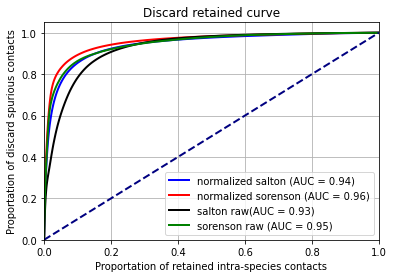

In [37]:
import matplotlib.pyplot as plt

plt.figure()
lw = 2  # line width
plt.plot(fpr_salton_norm, tpr_salton_norm, color='blue',
         lw=lw, label=f'normalized salton (AUC = {roc_auc_salton_norm:.2f})')
plt.plot(fpr_sorenson_norm, tpr_sorenson_norm, color="red", 
        lw=lw, label=f'normalized sorenson (AUC = {roc_auc_sorenson_norm:.2f})')
plt.plot(fpr_salton_raw, tpr_salton_raw, color='black',
         lw=lw, label=f'salton raw(AUC = {roc_auc_salton_raw:.2f})')
plt.plot(fpr_sorenson_raw, tpr_sorenson_raw, color="green", 
        lw=lw, label=f'sorenson raw (AUC = {roc_auc_sorenson_raw:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Proportation of retained intra-species contacts')
plt.ylabel('Proportation of discard spurious contacts')
plt.title('Discard retained curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

#### question: if there are multiple contacts for the same pairs of contigs, I should count it as 1 when calculate the multiple contacts or counted as the number as it is?


In [22]:
data

array([1, 1, 1, ..., 2, 3, 1], dtype=uint32)